# K-means 1D - Implementação com OpenMP (CPU)

---

Este notebook tem a implementação da **etapa 1: versão paralelizada com o uso do OpenMP (CPU)** do K-means. 

 O que será feito: 
1. **Gerar os dados** de forma pseudoaleatória e reprodutiva em um formato com 1 coluna e sem cabeçalho. 
2. **Implementação da opção A (Reduction)**: Criar `kmeans_1d_parallel_reduction.c` paralelizando os laços `assignment_step` e `update_step` usando `#pragma omp reduction`.
3. **Compilação e benchmark da versão Reduction**: Executar testes com diferentes configurações de threads e políticas de escalonamento (`static`, `dynamic` com chunks variados) para medir Speedup e Eficiência.
4. **Implementar versão paralela com Critical**: Criar `kmeans_1d_parallel_critical.c` usando `#pragma omp critical` no `update_step` como alternativa ao reduction. 
5. **Compilaçãp e benchmark da versão Critical**: Realizar os testes similares ao feitos para à versão reduction. 
6. **Analisar desempenho**: Gerar gráficos de Speedup e Eficiência comparando as implementações. 

### 1. Geração dos dados pseudoaleatórios e reprodutivos

Será usado a biblioteca `NumPy` para gerar dados sintéticos 1D que serão usados posteriormente no K-means. O processo garante a reprodutibilidade. 

A geração consiste em: 
1. Fixar a semente aleatória `np.random.seed(24)`para garantir reprodutibilidade.
2. Criar pontos distribuídos em faixas distintas (ex: 0, 10, 20, 30) usando distribuição normal.
3. Gerar três conjuntos de teste com tamanhos crescentes:
	- Pequeno: N=10⁴ pontos, K=4 clusters
	- Médio: N=10⁵ pontos, K=8 clusters
	- Grande: N=10⁶ pontos, K=16 clusters

4. Selecionar centróides iniciais aleatoriamente dos dados gerados para cada conjunto.
5. Embaralhar os pontos usando `np.random.shuffle`
6. Converter os dados para DataFrame do pandas e salvar em arquivos CSV (1 coluna, sem cabeçalho, sem índice) usando `to_csv(index=False, header=False)`:
	- `dados_*.csv` contendo os N pontos
	- `centroides_*.csv` contendo os K centróides iniciais

In [11]:
# Importar as bibliotecas necessárias
import numpy as np
import pandas as pd
import os

# Fixar semente para reprodutibilidade
np.random.seed(24)

def gerar_dados_clusters(N, K, faixas, desvio=2.0, nome_base=''):
    """
    Gera dados 1D com K clusters em faixas distintas
    """
    pontos_por_cluster = N // K
    pontos = []
    
    print(f"\n{'='*60}")
    print(f"Gerando conjunto: {nome_base.upper()}")
    print(f"{'='*60}")
    print(f"N = {N:,} pontos")
    print(f"K = {K} clusters")
    print(f"Centros reais dos clusters: {faixas}")
    print(f"Desvio padrão: {desvio}")
    
    # Gerar pontos ao redor de cada centro
    for i, centro in enumerate(faixas):
        pontos_cluster = np.random.normal(centro, desvio, pontos_por_cluster)
        pontos.extend(pontos_cluster)
        print(f"  Cluster {i}: ~{pontos_por_cluster:,} pontos ao redor de {centro}")
    
    # Adicionar pontos restantes (se N não for divisível por K)
    pontos_restantes = N - len(pontos)
    if pontos_restantes > 0:
        centro_extra = np.random.choice(faixas)
        pontos_extras = np.random.normal(centro_extra, desvio, pontos_restantes)
        pontos.extend(pontos_extras)
    
    # Converter para array e embaralhar
    pontos = np.array(pontos)
    np.random.shuffle(pontos)
    
    # Gerar centróides iniciais (escolher K pontos aleatórios dos dados)
    indices = np.random.choice(len(pontos), K, replace=False)
    centroides_iniciais = pontos[indices]
    
    print(f"\nCentróides iniciais escolhidos: {centroides_iniciais}")
    
    # Converter para DataFrame do pandas
    df_dados = pd.DataFrame(pontos)
    df_centroides = pd.DataFrame(centroides_iniciais)
    
    # Salvar em CSV (sem índice, sem cabeçalho) - usando ../ para subir um nível
    arquivo_dados = f'../dados/dados_{nome_base}.csv'
    arquivo_centroides = f'../dados/centroides_{nome_base}.csv'
    
    df_dados.to_csv(arquivo_dados, index=False, header=False)
    df_centroides.to_csv(arquivo_centroides, index=False, header=False)
    
    print(f"\nArquivos salvos:")
    print(f"  - {arquivo_dados}")
    print(f"  - {arquivo_centroides}")
    
    return pontos, centroides_iniciais, faixas

# Conjunto pequeno: N=10^4, K=4
faixas_pequeno = [0, 10, 20, 30]
N_pequeno = 10**4
K_pequeno = 4

dados_pequeno, cent_pequeno, faixas_p = gerar_dados_clusters(
    N=N_pequeno,
    K=K_pequeno,
    faixas=faixas_pequeno,
    desvio=2.0,
    nome_base='pequeno'
)

# Conjunto médio: N=10^5, K=8
faixas_medio = [0, 10, 20, 30, 40, 50, 60, 70]
N_medio = 10**5
K_medio = 8

dados_medio, cent_medio, faixas_m = gerar_dados_clusters(
    N=N_medio,
    K=K_medio,
    faixas=faixas_medio,
    desvio=2.5,
    nome_base='medio'
)

# Conjunto grande: N=10^6, K=16
faixas_grande = [i*10 for i in range(16)]  
N_grande = 10**6
K_grande = 16

dados_grande, cent_grande, faixas_g = gerar_dados_clusters(
    N=N_grande,
    K=K_grande,
    faixas=faixas_grande,
    desvio=3.0,
    nome_base='grande'
)

print(f"\n{'='*60}")
print("Resumo dos dados gerados")
print(f"{'='*60}")
print(f"Pequeno: {N_pequeno:,} pontos, {K_pequeno} clusters")
print(f"Médio: {N_medio:,} pontos, {K_medio} clusters")
print(f"Grande: {N_grande:,} pontos, {K_grande} clusters")
print(f"\nTodos os arquivos foram salvos na pasta '../dados/'")


Gerando conjunto: PEQUENO
N = 10,000 pontos
K = 4 clusters
Centros reais dos clusters: [0, 10, 20, 30]
Desvio padrão: 2.0
  Cluster 0: ~2,500 pontos ao redor de 0
  Cluster 1: ~2,500 pontos ao redor de 10
  Cluster 2: ~2,500 pontos ao redor de 20
  Cluster 3: ~2,500 pontos ao redor de 30

Centróides iniciais escolhidos: [21.93701747 32.87325466  9.31181049 20.97084085]

Arquivos salvos:
  - ../dados/dados_pequeno.csv
  - ../dados/centroides_pequeno.csv

Gerando conjunto: MEDIO
N = 100,000 pontos
K = 8 clusters
Centros reais dos clusters: [0, 10, 20, 30, 40, 50, 60, 70]
Desvio padrão: 2.5
  Cluster 0: ~12,500 pontos ao redor de 0
  Cluster 1: ~12,500 pontos ao redor de 10
  Cluster 2: ~12,500 pontos ao redor de 20
  Cluster 3: ~12,500 pontos ao redor de 30
  Cluster 4: ~12,500 pontos ao redor de 40
  Cluster 5: ~12,500 pontos ao redor de 50
  Cluster 6: ~12,500 pontos ao redor de 60
  Cluster 7: ~12,500 pontos ao redor de 70

Centróides iniciais escolhidos: [39.47531539 69.5562491  28.

### 2. Implementação da opção A (Reduction)

Esta é a implementação paralela `kmeans_1d_parallel_reduction.c` usando OpenMP com reduction.

- **assignment_step_1d:** O laço principal é paralelizado com `#pragma omp parallel for` e usa `reduction(+:sse)` para acumular o SSE. 

- **update_step_1d:** O laço de acumulação é paralelizado usando `reduction(+:sum[:K], cnt[:K])` para somar pontos e contar elementos de cada cluster. 

- **Medição de Tempo:** O main usa `omp_get_wtime()` fornecendo medição. 

- **Agendamento:** Usa `schedule(runtime)` para permitir controle da política de escalonamento (static, dynamic, guided) via variável de ambiente `OMP_SCHEDULE` sem necessidade de recompilar.

- **Parâmetros:** Adiciona número de threads como terceiro argumento na linha de comando, configurado via `omp_set_num_threads()`.

Os resultados (centróides e SSE) são **idênticos** à versão sequencial, garantindo corretude, mas com **tempo de execução reduzido** proporcionalmente ao número de threads disponíveis.


In [12]:
%%writefile kmeans_1d_parallel_reduction.c
/* kmeans_1d_parallel_reduction.c
   K-means 1D com OpenMP usando REDUCTION
   - Paraleliza assignment_step com reduction para SSE
   - Paraleliza update_step com reduction para sum e count
   
   Compilar: gcc -O2 -std=c99 -fopenmp kmeans_1d_parallel_reduction.c -o kmeans_1d_parallel_reduction -lm
   Uso:      ./kmeans_1d_parallel_reduction dados.csv centroides_iniciais.csv [num_threads] [max_iter=100] [eps=1e-6] [assign.csv] [centroids.csv] [sse_evolution.csv]
*/
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h>

/* ---------- util CSV 1D: cada linha tem 1 número ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }
    char line[8192];
    int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;
        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f);
    *n_out = R;
    return A;
}

static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

/* ---------- k-means 1D PARALELO COM REDUCTION ---------- */

/* assignment: para cada X[i], encontra c com menor (X[i]-C[c])^2 
   PARALELIZADO: usa reduction para somar SSE */
static double assignment_step_1d(const double *X, const double *C, int *assign, int N, int K){
    double sse = 0.0;
    
    #pragma omp parallel for reduction(+:sse) schedule(runtime)
    for(int i=0; i<N; i++){
        int best = -1;
        double bestd = 1e300;
        for(int c=0; c<K; c++){
            double diff = X[i] - C[c];
            double d = diff*diff;
            if(d < bestd){ bestd = d; best = c; }
        }
        assign[i] = best;
        sse += bestd;
    }
    return sse;
}

/* update: média dos pontos de cada cluster (1D)
   PARALELIZADO: usa arrays de reduction para sum e count */
static void update_step_1d(const double *X, double *C, const int *assign, int N, int K){
    double *sum = (double*)calloc((size_t)K, sizeof(double));
    int *cnt = (int*)calloc((size_t)K, sizeof(int));
    if(!sum || !cnt){ fprintf(stderr,"Sem memoria no update\n"); exit(1); }
    
    // Paralelizar usando array reduction
    #pragma omp parallel for reduction(+:sum[:K],cnt[:K]) schedule(runtime)
    for(int i=0; i<N; i++){
        int c = assign[i];
        sum[c] += X[i];
        cnt[c] += 1;
    }
    
    // Atualizar centróides
    for(int c=0; c<K; c++){
        if(cnt[c] > 0) C[c] = sum[c] / (double)cnt[c];
        else           C[c] = X[0]; // cluster vazio recebe primeiro ponto
    }
    
    free(sum); 
    free(cnt);
}

static void kmeans_1d(const double *X, double *C, int *assign,
                      int N, int K, int max_iter, double eps,
                      int *iters_out, double *sse_out, const char *sse_path)
{
    // Abrir arquivo para salvar evolução do SSE
    FILE *sse_file = NULL;
    if(sse_path){
        sse_file = fopen(sse_path, "w");
        if(sse_file) fprintf(sse_file, "iteration,sse\n");
    }
    
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;
    
    for(it=0; it<max_iter; it++){
        sse = assignment_step_1d(X, C, assign, N, K);
        
        // Salvar SSE desta iteração
        if(sse_file) fprintf(sse_file, "%d,%.6f\n", it, sse);
        
        /* parada por variação relativa do SSE */
        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);
        if(rel < eps){ it++; break; }
        
        update_step_1d(X, C, assign, N, K);
        prev_sse = sse;
    }
    
    // Fechar arquivo de evolução do SSE
    if(sse_file) fclose(sse_file);
    
    *iters_out = it;
    *sse_out = sse;
}

/* ---------- main ---------- */

int main(int argc, char **argv){
    if(argc < 3){
        printf("Uso: %s dados.csv centroides_iniciais.csv [num_threads=4] [max_iter=100] [eps=1e-6] [assign.csv] [centroids.csv] [sse_evolution.csv]\n", argv[0]);
        printf("Obs: arquivos CSV com 1 coluna (1 valor por linha), sem cabeçalho\n");
        return 1;
    }
    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int num_threads = (argc>3)? atoi(argv[3]) : 4;
    int max_iter = (argc>4)? atoi(argv[4]) : 100;
    double eps   = (argc>5)? atof(argv[5]) : 1e-6;
    const char *outAssign   = (argc>6)? argv[6] : NULL;
    const char *outCentroid = (argc>7)? argv[7] : NULL;
    const char *outSSE      = (argc>8)? argv[8] : NULL;
    
    if(max_iter <= 0 || eps <= 0.0){
        fprintf(stderr,"Parâmetros inválidos: max_iter>0 e eps>0\n");
        return 1;
    }
    
    // Configurar número de threads OpenMP
    omp_set_num_threads(num_threads);
    
    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    double *C = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C); exit(1); }
    
    double t0 = omp_get_wtime();
    int iters = 0; double sse = 0.0;
    kmeans_1d(X, C, assign, N, K, max_iter, eps, &iters, &sse, outSSE);
    double t1 = omp_get_wtime();
    
    double ms = (t1 - t0) * 1000.0;
    
    printf("K-means 1D (OpenMP - Reduction)\n");
    printf("N=%d K=%d max_iter=%d eps=%g threads=%d\n", N, K, max_iter, eps, num_threads);
    printf("Iterações: %d | SSE final: %.6f | Tempo: %.1f ms\n", iters, sse, ms);
    
    write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C, K);
    
    free(assign); free(X); free(C);
    return 0;
}


Overwriting kmeans_1d_parallel_reduction.c


### 3. Compilação e benchmark da versão Reduction

Esta etapa compila o código paralelo e executa testes para avaliar o desempenho com diferentes configurações de threads e políticas de escalonamento.

- **Compilação:** O código é compilado com as flags `-O2 -std=c99 -fopenmp -lm`, onde `-fopenmp` habilita o suporte OpenMP e `-O2` otimiza o código para desempenho.

- **Baseline Sequencial:** Primeiro, o script executa a versão sequencial para obter o tempo de referência usado nos cálculos de speedup. Este tempo é extraído e armazenado para comparação.

- **Configurações Testadas:**
	- **Threads:** 1, 2, 4, 8 (testando escalabilidade)
	- **Políticas de escalonamento:** static, dynamic com chunks (1, 10, 100), guided
	- **Conjunto de dados:** Conjunto grande (N=1M, K=16)

- **Controle de Escalonamento:** A variável de ambiente `OMP_SCHEDULE` controla a política de escalonamento em tempo de execução. Como o código usa `schedule(runtime)`, é possível testar diferentes políticas sem recompilar, simplesmente alterando esta variável antes de cada execução.

- **Métricas Calculadas:**
	- **Speedup:** Razão entre tempo sequencial e tempo paralelo (T_seq / T_parallel). Indica quantas vezes o código paralelo é mais rápido.
	- **Eficiência:** Speedup normalizado pelo número de threads (Speedup / threads × 100%). Valores próximos a 100% indicam uso eficiente dos recursos de processamento.

- **Processo Automatizado:** O script itera por todas as combinações de threads e políticas de escalonamento, executando o programa, extraindo métricas (tempo, iterações, SSE), calculando speedup e eficiência, e salvando tudo em formato CSV.

- **Saída:** Os resultados são salvos em `resultados_reduction/benchmark_reduction.csv` contendo: threads, schedule, tempo, speedup, eficiência, iterações e SSE para cada configuração testada. Este arquivo será usado posteriormente para análise e geração de gráficos comparativos.

In [4]:
%%bash

# Compilar a versão paralela com reduction
gcc -O2 -std=c99 -fopenmp kmeans_1d_parallel_reduction.c -o kmeans_1d_parallel_reduction -lm

# Tentar ler de um arquivo de log se existir, senão executar
if [ -f "../resultados/tempo_grande.txt" ]; then
    tempo_seq=$(grep "Tempo:" ../resultados/tempo_grande.txt | grep -oP 'Tempo: \K[\d.]+(?= ms)')
else
    echo "Executando baseline sequencial..."
    cd ../etapa_0 2>/dev/null || cd ../etapa_0_sequencial 2>/dev/null || mkdir -p ../etapa_0
    
    # Executar baseline se o executável existir
    if [ -f "kmeans_1d_naive" ]; then
        ./kmeans_1d_naive ../dados/dados_grande.csv ../dados/centroides_grande.csv 100 1e-6 \
            ../resultados/assign_grande.csv ../resultados/centroids_grande.csv ../resultados/sse_evolution_grande.csv \
            | tee ../resultados/tempo_grande.txt
        tempo_seq=$(grep "Tempo:" ../resultados/tempo_grande.txt | grep -oP 'Tempo: \K[\d.]+(?= ms)')
    fi
    cd - > /dev/null
fi

# Se ainda não encontrou, usar a própria versão paralela com 1 thread
if [ -z "$tempo_seq" ]; then
    echo "Usando versão paralela com 1 thread como baseline..."
    baseline_out=$(./kmeans_1d_parallel_reduction ../dados/dados_grande.csv ../dados/centroides_grande.csv \
        1 100 1e-6 \
        ../resultados/assign_baseline.csv ../resultados/centroids_baseline.csv ../resultados/sse_baseline.csv)
    
    tempo_seq=$(echo "$baseline_out" | grep -oP 'Tempo: \K[\d.]+(?= ms)')
    echo "$baseline_out"
fi

echo ""
echo "Tempo sequencial (baseline): ${tempo_seq} ms"
echo ""

# Arquivo CSV para guardar resultados
echo "threads,schedule,tempo_ms,speedup,eficiencia,iteracoes,sse" > ../resultados/benchmark_reduction.csv

# Configurações de teste
threads_list=(1 2 4 8)
schedules=("static" "dynamic,1" "dynamic,10" "dynamic,100" "guided")

echo "Iniciando Benchmark - Versão Reduction"
echo ""

# Loop através de diferentes configurações
for threads in "${threads_list[@]}"; do
    for schedule in "${schedules[@]}"; do
        echo "Testando: threads=${threads}, schedule=${schedule}"
        
        export OMP_SCHEDULE="${schedule}"
        
        output=$(./kmeans_1d_parallel_reduction ../dados/dados_grande.csv ../dados/centroides_grande.csv \
            ${threads} 100 1e-6 \
            ../resultados/assign_reduction_${threads}_${schedule//,/_}.csv \
            ../resultados/centroids_reduction_${threads}_${schedule//,/_}.csv \
            ../resultados/sse_reduction_${threads}_${schedule//,/_}.csv 2>&1)
        
        # Extrair métricas - CORRIGIDO: busca especificamente após "Tempo:"
        tempo=$(echo "$output" | grep -oP 'Tempo: \K[\d.]+(?= ms)')
        iteracoes=$(echo "$output" | grep -oP 'Iterações: \K\d+')
        sse=$(echo "$output" | grep -oP 'SSE final: \K[\d.]+')
        
        # Calcular Speedup e Eficiência
        if [ ! -z "$tempo" ] && [ ! -z "$tempo_seq" ]; then
            speedup=$(awk "BEGIN {printf \"%.4f\", ${tempo_seq} / ${tempo}}")
            eficiencia_pct=$(awk "BEGIN {printf \"%.2f\", (${tempo_seq} / ${tempo}) / ${threads} * 100}")
            eficiencia=$(awk "BEGIN {printf \"%.4f\", (${tempo_seq} / ${tempo}) / ${threads}}")
        else
            speedup="0"
            eficiencia="0"
            eficiencia_pct="0"
        fi
        
        echo "  Tempo: ${tempo} ms | Speedup: ${speedup}x | Eficiência: ${eficiencia_pct}%"
        
        echo "${threads},${schedule},${tempo},${speedup},${eficiencia},${iteracoes},${sse}" >> ../resultados/benchmark_reduction.csv
    done
    echo ""
done

echo "Resultados salvos em: ../resultados/benchmark_reduction.csv"



Tempo sequencial (baseline): 1979.9 ms

Iniciando Benchmark - Versão Reduction

Testando: threads=1, schedule=static
  Tempo: 1376.1 ms | Speedup: 1.4388x | Eficiência: 143.88%
Testando: threads=1, schedule=dynamic,1
  Tempo: 5476.6 ms | Speedup: 0.3615x | Eficiência: 36.15%
Testando: threads=1, schedule=dynamic,10
  Tempo: 2260.7 ms | Speedup: 0.8758x | Eficiência: 87.58%
Testando: threads=1, schedule=dynamic,100
  Tempo: 1887.1 ms | Speedup: 1.0492x | Eficiência: 104.92%
Testando: threads=1, schedule=guided
  Tempo: 1844.2 ms | Speedup: 1.0736x | Eficiência: 107.36%

Testando: threads=2, schedule=static
  Tempo: 959.9 ms | Speedup: 2.0626x | Eficiência: 103.13%
Testando: threads=2, schedule=dynamic,1
  Tempo: 7342.4 ms | Speedup: 0.2697x | Eficiência: 13.48%
Testando: threads=2, schedule=dynamic,10
  Tempo: 1690.0 ms | Speedup: 1.1715x | Eficiência: 58.58%
Testando: threads=2, schedule=dynamic,100
  Tempo: 1282.3 ms | Speedup: 1.5440x | Eficiência: 77.20%
Testando: threads=2, schedu

### 4. **Implementar versão paralela com Critical**


Esta é a implementação paralela `kmeans_1d_parallel_critical.c` usando **critical sections** do OpenMP como alternativa ao reduction.

- **assignment_step_1d:** O laço principal  é paralelizado com `#pragma omp parallel for`. Para acumular o SSE utiliza `#pragma omp critical` ao invés de reduction.

- **update_step_1d:** O laço é paralelizado, mas usa `#pragma omp critical` para proteger as atualizações de `sum[c]` e `cnt[c]`. 

- **Medição de Tempo:** Usa `omp_get_wtime()` para medição precisa de wall-clock time, igual à versão reduction.

- **Agendamento:** Utiliza `schedule(runtime)` para permitir controle via `OMP_SCHEDULE`.

Os resultados (centróides e SSE) são **idênticos** às versões sequencial e reduction, mas o **tempo de execução será maior** devido ao overhead das seções críticas, especialmente com muitas threads.

In [6]:
%%writefile kmeans_1d_parallel_critical.c
/* kmeans_1d_parallel_critical.c
   K-means 1D com OpenMP usando CRITICAL SECTION
   - Paraleliza assignment_step com critical para acumular SSE
   - Paraleliza update_step com critical para atualizar sum e count
   
   Compilar: gcc -O2 -std=c99 -fopenmp kmeans_1d_parallel_critical.c -o kmeans_1d_parallel_critical -lm
   Uso:      ./kmeans_1d_parallel_critical dados.csv centroides_iniciais.csv [num_threads] [max_iter=100] [eps=1e-6] [assign.csv] [centroids.csv] [sse_evolution.csv]
*/
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h>

/* ---------- util CSV 1D: cada linha tem 1 número ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }
    char line[8192];
    int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;
        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f);
    *n_out = R;
    return A;
}

static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

/* ---------- k-means 1D PARALELO COM CRITICAL ---------- */

/* assignment: para cada X[i], encontra c com menor (X[i]-C[c])^2 
   PARALELIZADO: usa critical section para somar SSE */
static double assignment_step_1d(const double *X, const double *C, int *assign, int N, int K){
    double sse = 0.0;
    
    #pragma omp parallel for schedule(runtime)
    for(int i=0; i<N; i++){
        int best = -1;
        double bestd = 1e300;
        for(int c=0; c<K; c++){
            double diff = X[i] - C[c];
            double d = diff*diff;
            if(d < bestd){ bestd = d; best = c; }
        }
        assign[i] = best;
        
        // Usar critical section para acumular SSE de forma segura
        #pragma omp critical
        {
            sse += bestd;
        }
    }
    return sse;
}

/* update: média dos pontos de cada cluster (1D)
   PARALELIZADO: usa critical section para atualizar sum e count */
static void update_step_1d(const double *X, double *C, const int *assign, int N, int K){
    double *sum = (double*)calloc((size_t)K, sizeof(double));
    int *cnt = (int*)calloc((size_t)K, sizeof(int));
    if(!sum || !cnt){ fprintf(stderr,"Sem memoria no update\n"); exit(1); }
    
    // Paralelizar com critical section para atualizações seguras
    #pragma omp parallel for schedule(runtime)
    for(int i=0; i<N; i++){
        int c = assign[i];
        
        // Usar critical section para atualizar sum e count
        #pragma omp critical
        {
            sum[c] += X[i];
            cnt[c] += 1;
        }
    }
    
    // Atualizar centróides
    for(int c=0; c<K; c++){
        if(cnt[c] > 0) C[c] = sum[c] / (double)cnt[c];
        else           C[c] = X[0]; // cluster vazio recebe primeiro ponto
    }
    
    free(sum); 
    free(cnt);
}

static void kmeans_1d(const double *X, double *C, int *assign,
                      int N, int K, int max_iter, double eps,
                      int *iters_out, double *sse_out, const char *sse_path)
{
    // Abrir arquivo para salvar evolução do SSE
    FILE *sse_file = NULL;
    if(sse_path){
        sse_file = fopen(sse_path, "w");
        if(sse_file) fprintf(sse_file, "iteration,sse\n");
    }
    
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;
    
    for(it=0; it<max_iter; it++){
        sse = assignment_step_1d(X, C, assign, N, K);
        
        // Salvar SSE desta iteração
        if(sse_file) fprintf(sse_file, "%d,%.6f\n", it, sse);
        
        /* parada por variação relativa do SSE */
        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);
        if(rel < eps){ it++; break; }
        
        update_step_1d(X, C, assign, N, K);
        prev_sse = sse;
    }
    
    // Fechar arquivo de evolução do SSE
    if(sse_file) fclose(sse_file);
    
    *iters_out = it;
    *sse_out = sse;
}

/* ---------- main ---------- */

int main(int argc, char **argv){
    if(argc < 3){
        printf("Uso: %s dados.csv centroides_iniciais.csv [num_threads=4] [max_iter=100] [eps=1e-6] [assign.csv] [centroids.csv] [sse_evolution.csv]\n", argv[0]);
        printf("Obs: arquivos CSV com 1 coluna (1 valor por linha), sem cabeçalho\n");
        return 1;
    }
    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int num_threads = (argc>3)? atoi(argv[3]) : 4;
    int max_iter = (argc>4)? atoi(argv[4]) : 100;
    double eps   = (argc>5)? atof(argv[5]) : 1e-6;
    const char *outAssign   = (argc>6)? argv[6] : NULL;
    const char *outCentroid = (argc>7)? argv[7] : NULL;
    const char *outSSE      = (argc>8)? argv[8] : NULL;
    
    if(max_iter <= 0 || eps <= 0.0){
        fprintf(stderr,"Parâmetros inválidos: max_iter>0 e eps>0\n");
        return 1;
    }
    
    // Configurar número de threads OpenMP
    omp_set_num_threads(num_threads);
    
    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    double *C = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C); exit(1); }
    
    double t0 = omp_get_wtime();
    int iters = 0; double sse = 0.0;
    kmeans_1d(X, C, assign, N, K, max_iter, eps, &iters, &sse, outSSE);
    double t1 = omp_get_wtime();
    
    double ms = (t1 - t0) * 1000.0;
    
    printf("K-means 1D (OpenMP - Critical)\n");
    printf("N=%d K=%d max_iter=%d eps=%g threads=%d\n", N, K, max_iter, eps, num_threads);
    printf("Iterações: %d | SSE final: %.6f | Tempo: %.1f ms\n", iters, sse, ms);
    
    write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C, K);
    
    free(assign); free(X); free(C);
    return 0;
}


Overwriting kmeans_1d_parallel_critical.c


### 5. **Compilação e benchmark da versão Critical**

Esta etapa compila a versão com seções críticas e executa os mesmos testes da versão reduction.

- **Compilação:** O código é compilado com as mesmas flags: `-O2 -std=c99 -fopenmp -lm`.

- **Baseline Compartilhado:** Utiliza o mesmo tempo sequencial de referência da versão reduction.

- **Configurações Testadas:**
	- **Threads:** 1, 2, 4, 8
	- **Políticas de escalonamento:** static, dynamic (chunks 1, 10, 100), guided
	- **Conjunto de dados:** Conjunto grande (N=1M, K=16)

- **Controle de Escalonamento:** A variável `OMP_SCHEDULE` controla a política em tempo de execução via `schedule(runtime)`.

- **Métricas Calculadas:**
	- **Speedup:** T_seq / T_parallel
	- **Eficiência:** (Speedup / threads) × 100%

- **Comparação Esperada:** Esta versão deve apresentar speedups **menores** e eficiências **piores** que a versão reduction devido ao overhead das seções críticas. A contenção aumenta com mais threads, pois elas competem pelo acesso exclusivo, criando gargalos de serialização.

- **Saída:** Os resultados são salvos em `../resultados/benchmark_critical.csv` no mesmo formato da versão reduction, facilitando análises comparativas posteriores.

In [7]:
%%bash

# Compilar a versão paralela com critical
gcc -O2 -std=c99 -fopenmp kmeans_1d_parallel_critical.c -o kmeans_1d_parallel_critical -lm

# Ler tempo sequencial do baseline 
echo "Lendo tempo sequencial do baseline..."
tempo_seq=$(grep "Tempo:" ../resultados/tempo_grande.txt 2>/dev/null | grep -oP 'Tempo: \K[\d.]+(?= ms)')

if [ -z "$tempo_seq" ]; then
    echo "Usando baseline da versão reduction..."
    tempo_seq=$(head -2 ../resultados/benchmark_reduction.csv | tail -1 | cut -d',' -f3)
fi

echo "Tempo sequencial (baseline): ${tempo_seq} ms"
echo ""

# Arquivo CSV para guardar resultados
echo "threads,schedule,tempo_ms,speedup,eficiencia,iteracoes,sse" > ../resultados/benchmark_critical.csv

# Configurações de teste 
threads_list=(1 2 4 8)
schedules=("static" "dynamic,1" "dynamic,10" "dynamic,100" "guided")

echo "Iniciando Benchmark - Versão Critical"
echo ""

# Loop através de diferentes configurações
for threads in "${threads_list[@]}"; do
    for schedule in "${schedules[@]}"; do
        echo "Testando: threads=${threads}, schedule=${schedule}"
        
        export OMP_SCHEDULE="${schedule}"
        
        output=$(./kmeans_1d_parallel_critical ../dados/dados_grande.csv ../dados/centroides_grande.csv \
            ${threads} 100 1e-6 \
            ../resultados/assign_critical_${threads}_${schedule//,/_}.csv \
            ../resultados/centroids_critical_${threads}_${schedule//,/_}.csv \
            ../resultados/sse_critical_${threads}_${schedule//,/_}.csv 2>&1)
        
        # Extrair métricas
        tempo=$(echo "$output" | grep -oP 'Tempo: \K[\d.]+(?= ms)')
        iteracoes=$(echo "$output" | grep -oP 'Iterações: \K\d+')
        sse=$(echo "$output" | grep -oP 'SSE final: \K[\d.]+')
        
        # Calcular Speedup e Eficiência
        if [ ! -z "$tempo" ] && [ ! -z "$tempo_seq" ]; then
            speedup=$(awk "BEGIN {printf \"%.4f\", ${tempo_seq} / ${tempo}}")
            eficiencia_pct=$(awk "BEGIN {printf \"%.2f\", (${tempo_seq} / ${tempo}) / ${threads} * 100}")
            eficiencia=$(awk "BEGIN {printf \"%.4f\", (${tempo_seq} / ${tempo}) / ${threads}}")
        else
            speedup="0"
            eficiencia="0"
            eficiencia_pct="0"
        fi
        
        echo "  Tempo: ${tempo} ms | Speedup: ${speedup}x | Eficiência: ${eficiencia_pct}%"
        
        echo "${threads},${schedule},${tempo},${speedup},${eficiencia},${iteracoes},${sse}" >> ../resultados/benchmark_critical.csv
    done
    echo ""
done

echo "Resultados salvos em: ../resultados/benchmark_critical.csv"


Lendo tempo sequencial do baseline...
Tempo sequencial (baseline): 1979.9 ms

Iniciando Benchmark - Versão Critical

Testando: threads=1, schedule=static
  Tempo: 3017.1 ms | Speedup: 0.6562x | Eficiência: 65.62%
Testando: threads=1, schedule=dynamic,1
  Tempo: 6639.5 ms | Speedup: 0.2982x | Eficiência: 29.82%
Testando: threads=1, schedule=dynamic,10
  Tempo: 4374.5 ms | Speedup: 0.4526x | Eficiência: 45.26%
Testando: threads=1, schedule=dynamic,100
  Tempo: 4273.5 ms | Speedup: 0.4633x | Eficiência: 46.33%
Testando: threads=1, schedule=guided
  Tempo: 4228.8 ms | Speedup: 0.4682x | Eficiência: 46.82%

Testando: threads=2, schedule=static
  Tempo: 10953.9 ms | Speedup: 0.1807x | Eficiência: 9.04%
Testando: threads=2, schedule=dynamic,1
  Tempo: 19555.9 ms | Speedup: 0.1012x | Eficiência: 5.06%
Testando: threads=2, schedule=dynamic,10
  Tempo: 12558.4 ms | Speedup: 0.1577x | Eficiência: 7.88%
Testando: threads=2, schedule=dynamic,100
  Tempo: 10618.4 ms | Speedup: 0.1865x | Eficiência: 

### 6. Analisar desempenho: Gerar gráficos de Speedup e Eficiência comparando as implementações. 

Esta etapa compara as implementações Reduction e Critical através de gráficos de Speedup e Eficiência. 

Análise de Desempenho: Reduction vs Critical

Dados (schedule=static):
   versao  threads  tempo_ms  speedup  eficiencia_pct
Reduction        1    1376.1   1.4388          143.88
Reduction        2     959.9   2.0626          103.13
Reduction        4     666.3   2.9715           74.29
Reduction        8    1155.8   1.7130           21.41
 Critical        1    3017.1   0.6562           65.62
 Critical        2   10953.9   0.1807            9.04
 Critical        4   25543.8   0.0775            1.94
 Critical        8   31649.9   0.0626            0.78


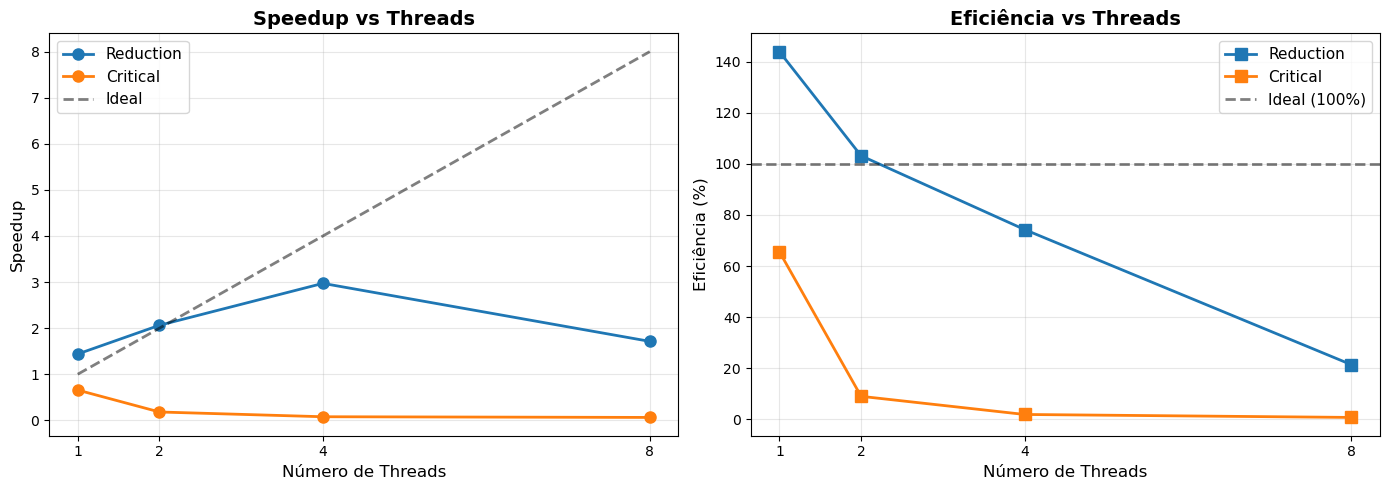


 Gráfico salvo em: ../resultados/analise_desempenho.png

Resumo Comparativo (8 threads, schedule=static):

Reduction:
  Speedup: 1.7130x
  Eficiência: 21.41%

Critical:
  Speedup: 0.0626x
  Eficiência: 0.78%

Vantagem da Reduction:
  Speedup: 1.6504x mais rápido
  Percentual: 2636.42% superior



In [25]:
import matplotlib.pyplot as plt
import csv

# Ler arquivos CSV 
def read_benchmark_csv(filepath):
    data = []
    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        
        for i, row in enumerate(reader):
            if len(row) != len(header):
                if len(row) == len(header) + 1:
                    row = [row[0], f"{row[1]},{row[2]}", row[3], row[4], row[5], row[6], row[7]]
            data.append(row)
    
    df = pd.DataFrame(data, columns=header)
    
    df['threads'] = pd.to_numeric(df['threads'])
    df['tempo_ms'] = pd.to_numeric(df['tempo_ms'])
    df['speedup'] = pd.to_numeric(df['speedup'])
    df['eficiencia'] = pd.to_numeric(df['eficiencia'])
    df['iteracoes'] = pd.to_numeric(df['iteracoes'])
    df['sse'] = pd.to_numeric(df['sse'])
    
    return df

# Carregar resultados dos benchmarks
df_reduction = read_benchmark_csv('../resultados/benchmark_reduction.csv')
df_critical = read_benchmark_csv('../resultados/benchmark_critical.csv')

df_reduction['versao'] = 'Reduction'
df_critical['versao'] = 'Critical'

df_combined = pd.concat([df_reduction, df_critical], ignore_index=True)
df_static = df_combined[df_combined['schedule'] == 'static'].copy()
df_static['eficiencia_pct'] = df_static['eficiencia'] * 100

print("="*60)
print("Análise de Desempenho: Reduction vs Critical")
print("="*60)
print("\nDados (schedule=static):")
print(df_static[['versao', 'threads', 'tempo_ms', 'speedup', 'eficiencia_pct']].to_string(index=False))

# Preparar dados para os gráficos
threads_unique = sorted(df_static['threads'].unique())

# Criar figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# GRÁFICO 1: Speedup
for versao in ['Reduction', 'Critical']:
    data = df_static[df_static['versao'] == versao]
    axes[0].plot(data['threads'], data['speedup'], marker='o', linewidth=2, 
                markersize=8, label=versao)

# Linha de speedup ideal
axes[0].plot(threads_unique, threads_unique, 'k--', alpha=0.5, label='Ideal', linewidth=2)

axes[0].set_xlabel('Número de Threads', fontsize=12)
axes[0].set_ylabel('Speedup', fontsize=12)
axes[0].set_title('Speedup vs Threads', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(threads_unique)

# GRÁFICO 2: Eficiência
for versao in ['Reduction', 'Critical']:
    data = df_static[df_static['versao'] == versao]
    eficiencia_pct = data['eficiencia'] * 100
    axes[1].plot(data['threads'], eficiencia_pct, marker='s', linewidth=2, 
                markersize=8, label=versao)

# Linha de eficiência ideal (100%)
axes[1].axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)', linewidth=2)

axes[1].set_xlabel('Número de Threads', fontsize=12)
axes[1].set_ylabel('Eficiência (%)', fontsize=12)
axes[1].set_title('Eficiência vs Threads', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(threads_unique)

plt.tight_layout()
plt.savefig('../resultados/analise_desempenho.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Gráfico salvo em: ../resultados/analise_desempenho.png")

print("\n" + "="*60)
print("Resumo Comparativo (8 threads, schedule=static):")
print("="*60)

reduction_8 = df_static[(df_static['versao'] == 'Reduction') & (df_static['threads'] == 8)]
critical_8 = df_static[(df_static['versao'] == 'Critical') & (df_static['threads'] == 8)]

if not reduction_8.empty and not critical_8.empty:
    speedup_red = reduction_8['speedup'].values[0]
    speedup_crit = critical_8['speedup'].values[0]
    efic_red = reduction_8['eficiencia_pct'].values[0]
    efic_crit = critical_8['eficiencia_pct'].values[0]
    
    print(f"\nReduction:")
    print(f"  Speedup: {speedup_red:.4f}x")
    print(f"  Eficiência: {efic_red:.2f}%")
    
    print(f"\nCritical:")
    print(f"  Speedup: {speedup_crit:.4f}x")
    print(f"  Eficiência: {efic_crit:.2f}%")
    
    print(f"\nVantagem da Reduction:")
    print(f"  Speedup: {speedup_red - speedup_crit:.4f}x mais rápido")
    print(f"  Percentual: {((speedup_red/speedup_crit - 1) * 100):.2f}% superior")

print("\n" + "="*60)